# Sleep Apnea Detection - Audio Inference Pipeline
## Process wav files of any length and predict sleep apnea events
### Features: 30-second windows, 16kHz processing, 27 acoustic features

In [9]:
# Cell 1: Imports and Configuration
print("--- Sleep Apnea Audio Inference Pipeline ---")

import os
import time
import numpy as np
import pandas as pd
import librosa
import joblib
import json
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Configuration
TARGET_SAMPLE_RATE = 16000  # 16kHz for optimized processing (same as training)
FRAME_DURATION = 30.0  # seconds
OVERLAP_RATIO = 0.5  # 50% overlap
MODEL_PATH = '../models/sleep_apnea_model.pkl'
METADATA_PATH = '../models/model_metadata.json'

print(f"✅ Configuration loaded:")
print(f"   Sample Rate: {TARGET_SAMPLE_RATE} Hz")
print(f"   Frame Duration: {FRAME_DURATION} seconds")
print(f"   Overlap: {OVERLAP_RATIO*100}%")
print(f"   Model: {MODEL_PATH}")

--- Sleep Apnea Audio Inference Pipeline ---
✅ Configuration loaded:
   Sample Rate: 16000 Hz
   Frame Duration: 30.0 seconds
   Overlap: 50.0%
   Model: ../models/sleep_apnea_model.pkl


In [10]:
# Cell 2: Feature Extraction Functions (Identical to Training)
def extract_comprehensive_features(audio_frame, sample_rate):
    """Extract the same 27 features used in training"""
    try:
        if len(audio_frame) == 0:
            return None
            
        # Basic acoustic features
        rms = float(librosa.feature.rms(y=audio_frame).mean())
        zcr = float(librosa.feature.zero_crossing_rate(y=audio_frame).mean())
        centroid = float(librosa.feature.spectral_centroid(y=audio_frame, sr=sample_rate).mean())
        bandwidth = float(librosa.feature.spectral_bandwidth(y=audio_frame, sr=sample_rate).mean())
        rolloff = float(librosa.feature.spectral_rolloff(y=audio_frame, sr=sample_rate).mean())
        
        # MFCCs (first 8 coefficients)
        mfccs = librosa.feature.mfcc(y=audio_frame, sr=sample_rate, n_mfcc=8)
        mfcc_means = mfccs.mean(axis=1)
        mfcc_stds = mfccs.std(axis=1)
        
        # Temporal features for breathing patterns (5-second windows)
        window_size = int(5 * sample_rate)  # 5 seconds
        num_windows = len(audio_frame) // window_size
        
        if num_windows >= 2:
            rms_windows = []
            zcr_windows = []
            
            for i in range(num_windows):
                start_idx = i * window_size
                end_idx = start_idx + window_size
                window = audio_frame[start_idx:end_idx]
                
                rms_windows.append(librosa.feature.rms(y=window).mean())
                zcr_windows.append(librosa.feature.zero_crossing_rate(y=window).mean())
            
            rms_variability = float(np.std(rms_windows))
            zcr_variability = float(np.std(zcr_windows))
            breathing_regularity = float(1.0 / (1.0 + rms_variability))  # Higher = more regular
        else:
            rms_variability = 0.0
            zcr_variability = 0.0
            breathing_regularity = 0.5
        
        # Silence detection
        silence_threshold = np.percentile(np.abs(audio_frame), 20)  # Bottom 20% as silence
        silence_mask = np.abs(audio_frame) < silence_threshold
        silence_ratio = float(np.mean(silence_mask))
        
        # Breathing pause detection (continuous silence periods)
        silence_changes = np.diff(silence_mask.astype(int))
        pause_starts = np.where(silence_changes == 1)[0]
        pause_ends = np.where(silence_changes == -1)[0]
        
        if len(pause_starts) > 0 and len(pause_ends) > 0:
            if len(pause_ends) < len(pause_starts):
                pause_ends = np.append(pause_ends, len(audio_frame))
            pause_durations = (pause_ends[:len(pause_starts)] - pause_starts) / sample_rate
            avg_pause_duration = float(np.mean(pause_durations))
            max_pause_duration = float(np.max(pause_durations))
        else:
            avg_pause_duration = 0.0
            max_pause_duration = 0.0
        
        # Combine all features
        features = {
            'clean_rms': rms,
            'clean_zcr': zcr,
            'clean_centroid': centroid,
            'clean_bandwidth': bandwidth,
            'clean_rolloff': rolloff,
            'clean_rms_variability': rms_variability,
            'clean_zcr_variability': zcr_variability,
            'clean_breathing_regularity': breathing_regularity,
            'clean_silence_ratio': silence_ratio,
            'clean_avg_pause_duration': avg_pause_duration,
            'clean_max_pause_duration': max_pause_duration
        }
        
        # Add MFCCs
        for i, (mean_val, std_val) in enumerate(zip(mfcc_means, mfcc_stds), 1):
            features[f'clean_mfcc_{i}_mean'] = float(mean_val)
            features[f'clean_mfcc_{i}_std'] = float(std_val)
        
        return features
        
    except Exception as e:
        print(f"   ⚠️  Feature extraction error: {e}")
        return None

print("✅ Feature extraction functions loaded (27 features)")

✅ Feature extraction functions loaded (27 features)


In [11]:
# Cell 3: Model Loading Functions
def load_sleep_apnea_model():
    """Load the trained sleep apnea detection model and metadata"""
    try:
        # Load model
        model = joblib.load(MODEL_PATH)
        print(f"✅ Model loaded: {MODEL_PATH}")
        
        # Load metadata
        with open(METADATA_PATH, 'r') as f:
            metadata = json.load(f)
        print(f"✅ Metadata loaded: {METADATA_PATH}")
        
        # Display model info
        print(f"\n📋 MODEL INFO:")
        print(f"   Type: {metadata['model_info']['model_type']}")
        print(f"   Algorithm: {metadata['model_info']['algorithm']}")
        print(f"   Features: {metadata['features']['num_features']}")
        print(f"   Performance: F1={metadata['performance_metrics']['single_split']['f1_score']:.3f}")
        print(f"   Training Date: {metadata['model_info']['training_date'][:10]}")
        
        return model, metadata
        
    except FileNotFoundError as e:
        print(f"❌ Model files not found: {e}")
        print(f"   Make sure to run the patient_based_validation.ipynb notebook first to save the model")
        return None, None
    except Exception as e:
        print(f"❌ Error loading model: {e}")
        return None, None

def preprocess_features(features_df, feature_columns):
    """Apply the same preprocessing as training"""
    # Select only the required features
    X = features_df[feature_columns].copy()
    
    # Apply same preprocessing as training
    X = X.replace([np.inf, -np.inf], np.nan)
    X = X.fillna(X.median())
    
    return X

print("✅ Model loading functions ready")

✅ Model loading functions ready


In [12]:
# Cell 4: Audio Processing Pipeline
def process_audio_file(audio_path):
    """Process a single audio file and extract features from 30-second windows"""
    
    print(f"\n🎵 Processing: {audio_path}")
    
    try:
        # Load audio file
        audio, original_sr = librosa.load(audio_path, sr=None)
        duration = len(audio) / original_sr
        
        print(f"   📊 Original: {duration:.1f}s, {original_sr} Hz, {len(audio):,} samples")
        
        # Downsample to target sample rate if needed
        if original_sr != TARGET_SAMPLE_RATE:
            audio = librosa.resample(audio, orig_sr=original_sr, target_sr=TARGET_SAMPLE_RATE)
            print(f"   🔄 Downsampled to {TARGET_SAMPLE_RATE} Hz")
        
        # Calculate frame parameters
        frame_samples = int(FRAME_DURATION * TARGET_SAMPLE_RATE)
        step_samples = int(frame_samples * (1 - OVERLAP_RATIO))
        
        # Check if audio is long enough
        if len(audio) < frame_samples:
            print(f"   ⚠️  Audio too short ({duration:.1f}s < {FRAME_DURATION}s), skipping")
            return None
        
        # Extract features from overlapping frames
        features_list = []
        frame_count = 0
        
        for frame_start in range(0, len(audio) - frame_samples + 1, step_samples):
            frame_end = frame_start + frame_samples
            timestamp = frame_start / TARGET_SAMPLE_RATE
            
            # Extract audio frame
            audio_frame = audio[frame_start:frame_end]
            
            # Extract features
            features = extract_comprehensive_features(audio_frame, TARGET_SAMPLE_RATE)
            
            if features is not None:
                # Add metadata
                record = {
                    'audio_file': os.path.basename(audio_path),
                    'timestamp': timestamp,
                    'frame_duration': FRAME_DURATION,
                    'sample_rate': TARGET_SAMPLE_RATE,
                    **features
                }
                features_list.append(record)
                frame_count += 1
        
        print(f"   ✅ Extracted {frame_count} frames ({frame_count * FRAME_DURATION:.1f}s coverage)")
        
        if features_list:
            return pd.DataFrame(features_list)
        else:
            print(f"   ❌ No valid features extracted")
            return None
            
    except Exception as e:
        print(f"   ❌ Error processing {audio_path}: {e}")
        return None

def process_audio_folder(folder_path):
    """Process all wav files in a folder"""
    
    print(f"\n📁 Processing folder: {folder_path}")
    
    # Find all wav files
    wav_files = list(Path(folder_path).glob("*.wav"))
    
    if not wav_files:
        print(f"   ❌ No .wav files found in {folder_path}")
        return None
    
    print(f"   📊 Found {len(wav_files)} wav files")
    
    all_features = []
    
    for wav_file in wav_files:
        features_df = process_audio_file(str(wav_file))
        if features_df is not None:
            all_features.append(features_df)
    
    if all_features:
        combined_df = pd.concat(all_features, ignore_index=True)
        print(f"\n   ✅ Combined: {len(combined_df)} total frames from {len(all_features)} files")
        return combined_df
    else:
        print(f"   ❌ No features extracted from any file")
        return None

print("✅ Audio processing pipeline ready")

✅ Audio processing pipeline ready


In [13]:
# Cell 5: Prediction Pipeline
def predict_sleep_apnea(features_df, model, metadata):
    """Predict sleep apnea from extracted features"""
    
    print(f"\n🔮 Making predictions on {len(features_df)} frames...")
    
    try:
        # Preprocess features (same as training)
        X = preprocess_features(features_df, metadata['features']['feature_columns'])
        
        # Make predictions
        predictions = model.predict(X)
        probabilities = model.predict_proba(X)[:, 1]
        
        # Add predictions to dataframe
        results_df = features_df.copy()
        results_df['apnea_prediction'] = predictions
        results_df['apnea_probability'] = probabilities
        
        # Calculate summary statistics
        total_frames = len(results_df)
        apnea_frames = int(predictions.sum())
        apnea_percentage = (apnea_frames / total_frames) * 100
        avg_probability = probabilities.mean()
        max_probability = probabilities.max()
        
        print(f"\n📊 PREDICTION SUMMARY:")
        print(f"   Total frames: {total_frames}")
        print(f"   Apnea frames: {apnea_frames} ({apnea_percentage:.1f}%)")
        print(f"   Normal frames: {total_frames - apnea_frames} ({100-apnea_percentage:.1f}%)")
        print(f"   Average apnea probability: {avg_probability:.3f}")
        print(f"   Maximum apnea probability: {max_probability:.3f}")
        
        # Risk assessment based on percentage
        if apnea_percentage > 50:
            risk_level = "SEVERE"
            emoji = "🚨"
        elif apnea_percentage > 30:
            risk_level = "MODERATE-HIGH"
            emoji = "⚠️"
        elif apnea_percentage > 15:
            risk_level = "MODERATE"
            emoji = "⚠️"
        elif apnea_percentage > 5:
            risk_level = "MILD"
            emoji = "⚠️"
        else:
            risk_level = "LOW"
            emoji = "✅"
        
        print(f"\n{emoji} RISK ASSESSMENT: {risk_level}")
        
        return results_df, {
            'total_frames': total_frames,
            'apnea_frames': apnea_frames,
            'apnea_percentage': apnea_percentage,
            'avg_probability': avg_probability,
            'max_probability': max_probability,
            'risk_level': risk_level
        }
        
    except Exception as e:
        print(f"❌ Prediction error: {e}")
        return None, None

print("✅ Prediction pipeline ready")

✅ Prediction pipeline ready


In [14]:
# Cell 6: Visualization Functions
def visualize_predictions(results_df, summary):
    """Create visualizations of the predictions"""
    
    if results_df is None:
        print("❌ No data to visualize")
        return
    
    print("\n📊 Creating visualizations...")
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Sleep Apnea Detection Results', fontsize=16, fontweight='bold')
    
    # 1. Timeline of predictions
    ax1 = axes[0, 0]
    timestamps = results_df['timestamp'] / 60  # Convert to minutes
    colors = ['red' if pred == 1 else 'green' for pred in results_df['apnea_prediction']]
    ax1.scatter(timestamps, results_df['apnea_probability'], c=colors, alpha=0.6, s=20)
    ax1.axhline(y=0.5, color='black', linestyle='--', alpha=0.5, label='Decision threshold')
    ax1.set_xlabel('Time (minutes)')
    ax1.set_ylabel('Apnea Probability')
    ax1.set_title('Apnea Probability Timeline')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Probability distribution
    ax2 = axes[0, 1]
    ax2.hist(results_df['apnea_probability'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
    ax2.axvline(x=0.5, color='red', linestyle='--', label='Decision threshold')
    ax2.set_xlabel('Apnea Probability')
    ax2.set_ylabel('Frequency')
    ax2.set_title('Probability Distribution')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. Prediction summary pie chart
    ax3 = axes[1, 0]
    labels = ['Normal', 'Apnea']
    sizes = [summary['total_frames'] - summary['apnea_frames'], summary['apnea_frames']]
    colors = ['lightgreen', 'lightcoral']
    explode = (0, 0.1)  # explode the apnea slice
    ax3.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
            shadow=True, startangle=90)
    ax3.set_title('Prediction Distribution')
    
    # 4. Risk level summary
    ax4 = axes[1, 1]
    ax4.text(0.5, 0.7, f"Risk Level: {summary['risk_level']}", 
             ha='center', va='center', fontsize=20, fontweight='bold',
             transform=ax4.transAxes)
    ax4.text(0.5, 0.5, f"Apnea Rate: {summary['apnea_percentage']:.1f}%", 
             ha='center', va='center', fontsize=16,
             transform=ax4.transAxes)
    ax4.text(0.5, 0.3, f"Avg Probability: {summary['avg_probability']:.3f}", 
             ha='center', va='center', fontsize=14,
             transform=ax4.transAxes)
    ax4.set_xlim(0, 1)
    ax4.set_ylim(0, 1)
    ax4.axis('off')
    ax4.set_title('Summary Statistics')
    
    plt.tight_layout()
    plt.show()
    
    # Additional timeline plot for better detail
    plt.figure(figsize=(15, 4))
    plt.plot(timestamps, results_df['apnea_probability'], 'b-', alpha=0.7, linewidth=1)
    plt.scatter(timestamps[results_df['apnea_prediction'] == 1], 
                results_df[results_df['apnea_prediction'] == 1]['apnea_probability'], 
                c='red', s=30, alpha=0.8, label='Apnea detected')
    plt.axhline(y=0.5, color='black', linestyle='--', alpha=0.5, label='Decision threshold')
    plt.xlabel('Time (minutes)')
    plt.ylabel('Apnea Probability')
    plt.title('Detailed Apnea Detection Timeline')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

print("✅ Visualization functions ready")

✅ Visualization functions ready


In [15]:
# Cell 7: Main Inference Function
def run_sleep_apnea_inference(input_path, save_results=True):
    """Main function to run sleep apnea inference on audio file(s)"""
    
    print(f"🚀 SLEEP APNEA INFERENCE PIPELINE")
    print(f"={'='*60}")
    print(f"Input: {input_path}")
    print(f"Time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    
    # Step 1: Load model
    print(f"\n📦 Step 1: Loading model...")
    model, metadata = load_sleep_apnea_model()
    
    if model is None:
        print(f"❌ Cannot proceed without model")
        return None, None
    
    # Step 2: Process audio
    print(f"\n🎵 Step 2: Processing audio...")
    
    if os.path.isfile(input_path) and input_path.endswith('.wav'):
        # Single file
        features_df = process_audio_file(input_path)
    elif os.path.isdir(input_path):
        # Folder of files
        features_df = process_audio_folder(input_path)
    else:
        print(f"❌ Invalid input: {input_path} (must be .wav file or folder)")
        return None, None
    
    if features_df is None:
        print(f"❌ No features extracted")
        return None, None
    
    # Step 3: Make predictions
    print(f"\n🔮 Step 3: Making predictions...")
    results_df, summary = predict_sleep_apnea(features_df, model, metadata)
    
    if results_df is None:
        print(f"❌ Prediction failed")
        return None, None
    
    # Step 4: Save results
    if save_results:
        print(f"\n💾 Step 4: Saving results...")
        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        
        # Create results directory
        results_dir = '../results'
        os.makedirs(results_dir, exist_ok=True)
        
        # Save detailed results
        results_file = f'{results_dir}/sleep_apnea_predictions_{timestamp}.csv'
        results_df.to_csv(results_file, index=False)
        print(f"   ✅ Detailed results: {results_file}")
        
        # Save summary
        summary_file = f'{results_dir}/sleep_apnea_summary_{timestamp}.json'
        summary['input_path'] = input_path
        summary['timestamp'] = timestamp
        summary['model_info'] = metadata['model_info']
        
        with open(summary_file, 'w') as f:
            json.dump(summary, f, indent=2, default=str)
        print(f"   ✅ Summary: {summary_file}")
    
    # Step 5: Visualize
    print(f"\n📊 Step 5: Creating visualizations...")
    visualize_predictions(results_df, summary)
    
    print(f"\n🎉 INFERENCE COMPLETE!")
    print(f"{'='*60}")
    
    return results_df, summary

print("✅ Main inference function ready")

✅ Main inference function ready


🧪 USAGE EXAMPLES

📋 To use this notebook:

1. Single WAV file:
   results_df, summary = run_sleep_apnea_inference('path/to/audio.wav')

2. Folder of WAV files:
   results_df, summary = run_sleep_apnea_inference('path/to/audio_folder/')

3. Without saving results:
   results_df, summary = run_sleep_apnea_inference('audio.wav', save_results=False)

🔧 FEATURES:
   • Processes WAV files of any length
   • 30-second windows with 50% overlap
   • Automatic 16kHz downsampling
   • 27 acoustic features (same as training)
   • Real-time predictions and probabilities
   • Automatic visualizations
   • Results saved as CSV and JSON

⚠️  REQUIREMENTS:
   • Model must be trained first (run patient_based_validation.ipynb)
   • Audio files must be WAV format
   • Minimum 30 seconds of audio required

🎯 READY FOR INFERENCE!
   Uncomment and modify the example below to test:
🚀 SLEEP APNEA INFERENCE PIPELINE
Input: ../useful_sleep_sounds/full_mic_3.wav
Time: 2025-07-28 21:52:07

📦 Step 1: Loading model.

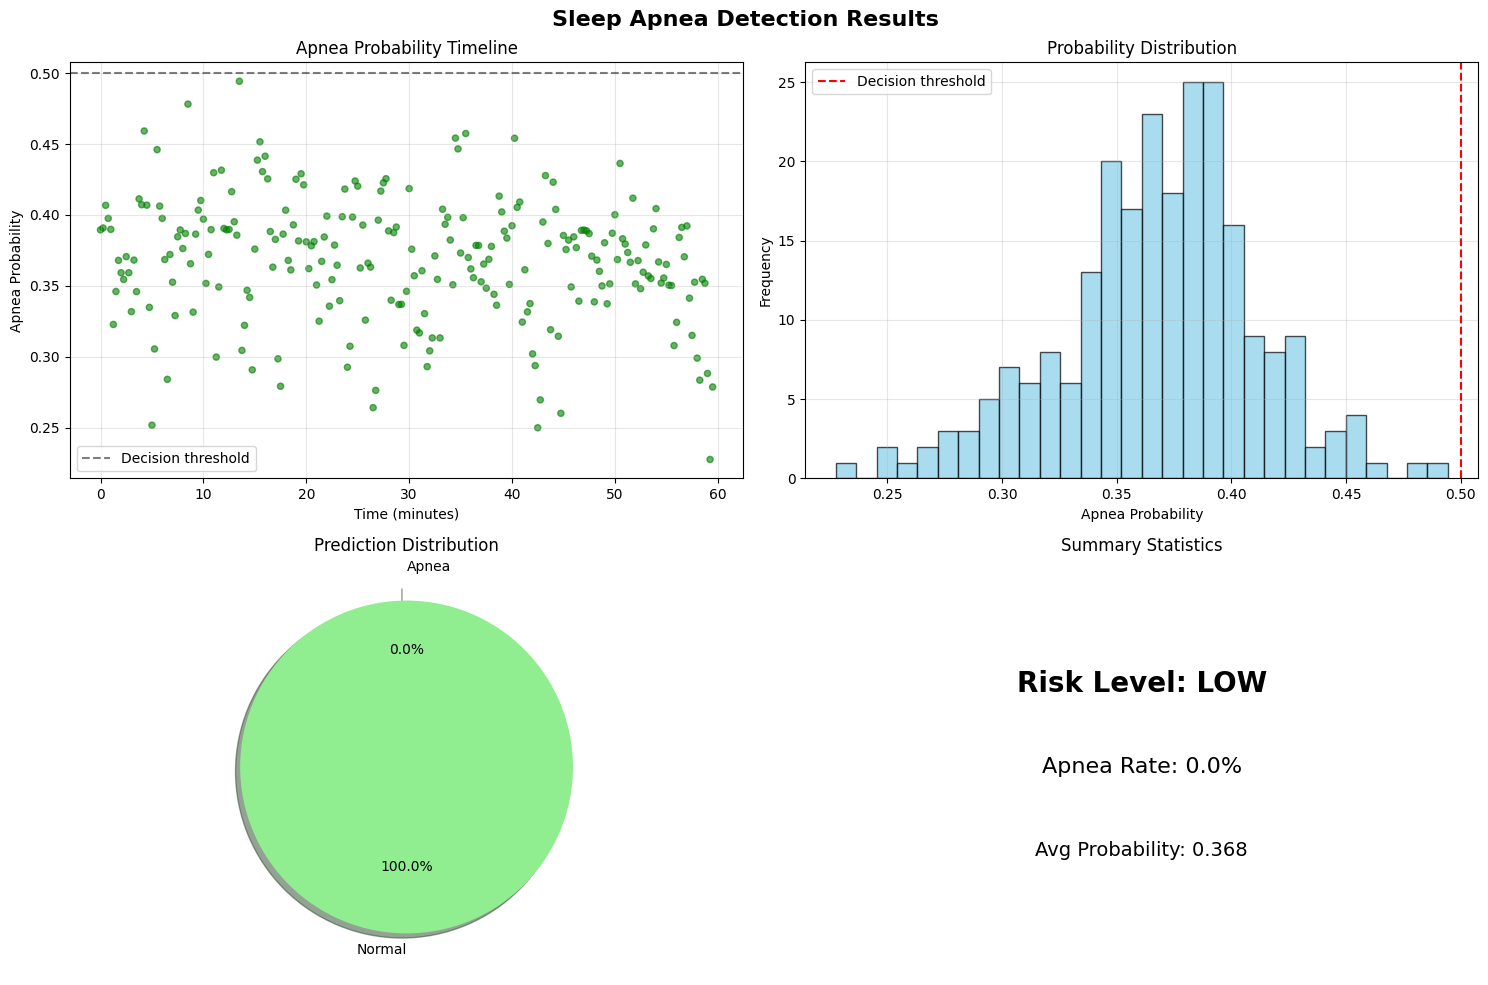

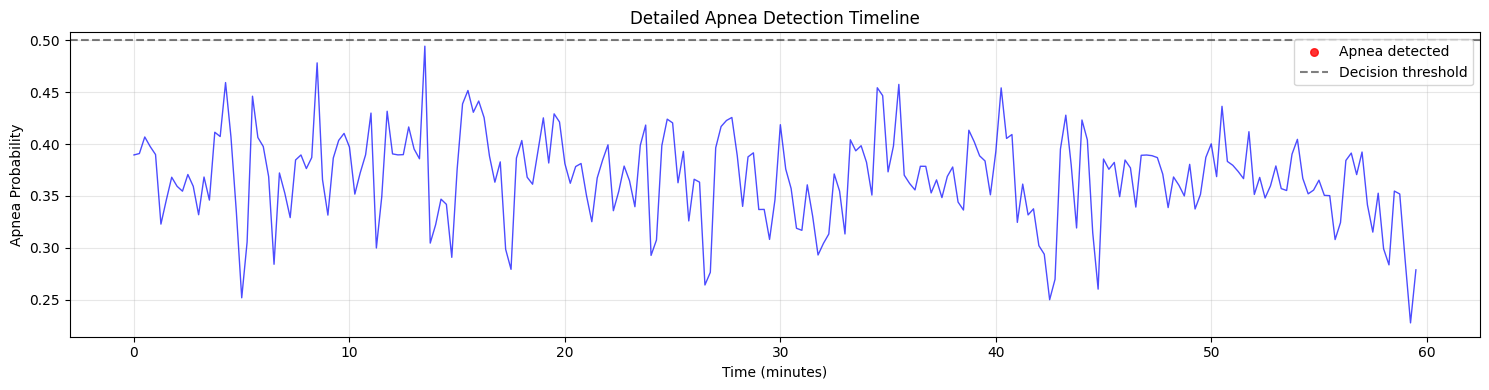


🎉 INFERENCE COMPLETE!


In [16]:
# Cell 8: Usage Examples and Testing
print("🧪 USAGE EXAMPLES")
print("="*50)

print("\n📋 To use this notebook:")
print("\n1. Single WAV file:")
print("   results_df, summary = run_sleep_apnea_inference('path/to/audio.wav')")

print("\n2. Folder of WAV files:")
print("   results_df, summary = run_sleep_apnea_inference('path/to/audio_folder/')")

print("\n3. Without saving results:")
print("   results_df, summary = run_sleep_apnea_inference('audio.wav', save_results=False)")

print("\n🔧 FEATURES:")
print("   • Processes WAV files of any length")
print("   • 30-second windows with 50% overlap")
print("   • Automatic 16kHz downsampling")
print("   • 27 acoustic features (same as training)")
print("   • Real-time predictions and probabilities")
print("   • Automatic visualizations")
print("   • Results saved as CSV and JSON")

print("\n⚠️  REQUIREMENTS:")
print("   • Model must be trained first (run patient_based_validation.ipynb)")
print("   • Audio files must be WAV format")
print("   • Minimum 30 seconds of audio required")

print("\n🎯 READY FOR INFERENCE!")
print("   Uncomment and modify the example below to test:")

# EXAMPLE USAGE (uncomment to test):
test_audio_path = '../useful_sleep_sounds/full_mic_3.wav'  # Replace with your audio file
if os.path.exists(test_audio_path):
    results_df, summary = run_sleep_apnea_inference(test_audio_path)
else:
    print(f"Test audio file not found: {test_audio_path}")
    print("Please provide a valid path to test the inference pipeline")